### Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import sys, os
sys.path.append(os.path.abspath(".."))  
from dataset import PACSDataset
from vit_grqo import ViTGRQO, grqo_loss_from_gradients
from encoder_decoder_vit import VisualDecoder, MultiheadAttn, DecoderAttn
from Visual_query_heads import QueryLosses, GRQO

### CONFIG 

In [3]:
import os
from datasets import load_dataset
from PIL import Image

# Your constants
DATA_ROOT = r"D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
BATCH_SIZE = 32
NUM_CLASSES = 7
NUM_EPOCHS = 5
LR = 1e-4
TOPK = 24
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset = load_dataset("flwrlabs/pacs", split="train")

# os.makedirs(DATA_ROOT, exist_ok=True)
# for domain in DOMAINS:
#     for cls in CLASSES:
#         os.makedirs(f"{DATA_ROOT}/{domain}/{cls}", exist_ok=True)

# for i, example in enumerate(dataset):
#     domain = example["domain"]  
#     label_idx = example["label"]  
#     label = CLASSES[label_idx]

#     if domain not in DOMAINS:
#         raise ValueError(f"Unexpected domain: {domain}. Expected one of {DOMAINS}")
#     if label not in CLASSES:
#         raise ValueError(f"Unexpected label: {label}. Expected one of {CLASSES}")
    
#     image = example["image"]
#     image.save(f"{DATA_ROOT}/{domain}/{label}/image_{i}.jpg")


### Data

In [29]:
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
pacs_data = PACSDataset(DATA_ROOT, DOMAINS, TRANSFORM, BATCH_SIZE)
ALL_DOMAINS = ['photo', 'art_painting', 'cartoon', 'sketch']
LEAVE_OUT = 'sketch'  
TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
VAL_DOMAIN = LEAVE_OUT

train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation loader
val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

### Model 

In [54]:
from transformers import ViTModel, AutoFeatureExtractor
import torch
import torch.nn as nn

#  resnet18 Backbone ---
dummy = torch.randn(1,3,224,224)
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
backbone = torch.nn.Sequential(*list(model.children())[:-2])
with torch.no_grad():
    dummy_out = backbone(dummy)
_,HIDDEN_DIM,_,_ = dummy_out.shape
# GRQO Hyperparameters ---
NUM_HEADS = 6
DROPOUT = 0.1
NUM_LAYERS = 3
DDROPOUT = 0.1
NUM_TOKENS = 16
TEMPERATURE = 0.1
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
LAMBDA_GRQO = 1.0
TEACHER_EMA = 0.99
NUM_CLASSES = 7
DECODER_DIM = 384

# GRQO Decoder ---
grqo_model = GRQO(
    Hidden_dim=DECODER_DIM,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    num_tokens=NUM_TOKENS,
    ddropout=DDROPOUT,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    temperature=TEMPERATURE,
    alpha=ALPHA,
    beta=BETA,
    tau=TAU,
    lambda_grqo=LAMBDA_GRQO,
    teacher_ema=TEACHER_EMA,
    reward_proxy="taylor"
)

# Full Model ---
class resnetGRQO(nn.Module):
    def __init__(self, backbone, grqo_model, HD):
        super().__init__()
        self.backbone = backbone
        self.grqo = grqo_model
        self.projection_head = nn.Linear(HD,384)

    def forward(self, x, labels=None):
        outputs = self.backbone(x)
        B,D,H,W = outputs.shape
        outputs = outputs.flatten(2).transpose(1,2)
        tokens = self.projection_head(outputs)
        return self.grqo(tokens, labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model initialized on {device}")
print(f"Hidden dim: {HIDDEN_DIM}, Num tokens: {NUM_TOKENS}")

Model initialized on cuda
Hidden dim: 512, Num tokens: 16


### training

In [21]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_grqo_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images, labels)
        
        # Extract losses
        loss = output['loss']
        cls_loss = output['cls_loss']
        grqo_loss = output['grqo_loss']
        preds = output['preds']
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        total_cls_loss += cls_loss.item() * images.size(0)
        total_grqo_loss += grqo_loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Cls: {cls_loss.item():.4f}, GRQO: {grqo_loss.item():.4f}')
    
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_grqo_loss = total_grqo_loss / total_samples
    accuracy = correct / total_samples
    
    return avg_loss, avg_cls_loss, avg_grqo_loss, accuracy

### evaluation

In [22]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # GRQO needs gradients even during validation
        with torch.set_grad_enabled(True):
            output = model(images, labels)
            preds = output['preds']
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

### finetuning 

In [55]:
ALL_DOMAINS = ['sketch', 'photo', 'art_painting', 'cartoon']
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Create data loaders
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)
    model = resnetGRQO(backbone, grqo_model, HIDDEN_DIM).to(device)
    FREEZE = False
    if FREEZE:
        for param in model.backbone.parameters():
            param.requires_grad = False
        print("backbone frozen")
    else:
        print("backbone trainable")

    # Ensure GRQO is trainable
    for param in model.grqo.parameters():
        param.requires_grad = True
        # Optimizer ---
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=0.01)
    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_cls, train_grqo, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
        
        # Validate  
        val_acc = validate(model, val_loader, DEVICE)
        
        print(f"Train - Loss: {train_loss:.4f}, Cls: {train_cls:.4f}, "
              f"GRQO: {train_grqo:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    lodo_results[VAL_DOMAIN] = best_val_acc
    print(f"Best Val Acc for {VAL_DOMAIN}: {best_val_acc:.4f}")

# Cell 8: Results Summary
print("\n" + "="*50)
print("LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average':15}: {avg_lodo:.4f}")
print("="*50)


=== LODO: Leaving out domain 'sketch' ===
backbone trainable

Epoch 1/5
Batch 0, Loss: 2.1913, Cls: 2.1314, GRQO: 0.0599
Batch 50, Loss: 0.2752, Cls: 0.2697, GRQO: 0.0056
Batch 100, Loss: 0.2863, Cls: 0.2819, GRQO: 0.0043
Batch 150, Loss: 0.4737, Cls: 0.4698, GRQO: 0.0039
Train - Loss: 0.5518, Cls: 0.5441, GRQO: 0.0077, Acc: 0.8247
Val Acc (sketch): 0.5687

Epoch 2/5
Batch 0, Loss: 0.2212, Cls: 0.2179, GRQO: 0.0032
Batch 50, Loss: 0.0799, Cls: 0.0769, GRQO: 0.0031
Batch 100, Loss: 0.0133, Cls: 0.0106, GRQO: 0.0027
Batch 150, Loss: 0.1221, Cls: 0.1196, GRQO: 0.0025
Train - Loss: 0.1224, Cls: 0.1194, GRQO: 0.0030, Acc: 0.9614
Val Acc (sketch): 0.6094

Epoch 3/5
Batch 0, Loss: 0.0500, Cls: 0.0477, GRQO: 0.0023
Batch 50, Loss: 0.0041, Cls: 0.0020, GRQO: 0.0021
Batch 100, Loss: 0.0151, Cls: 0.0129, GRQO: 0.0022
Batch 150, Loss: 0.0144, Cls: 0.0123, GRQO: 0.0021
Train - Loss: 0.0442, Cls: 0.0420, GRQO: 0.0022, Acc: 0.9854
Val Acc (sketch): 0.5344

Epoch 4/5
Batch 0, Loss: 0.0852, Cls: 0.083

### Baseline

In [60]:
print("\n=== Leave-One-Domain-Out (LODO) Training & Validation ===")
ALL_DOMAINS = ['sketch', 'photo', 'art_painting', 'cartoon']
lodo_results = {}  # store per-domain results

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out {LEAVE_OUT.upper()} for validation ===")
    
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Train loader (concat all train domains)
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Validation loader (only leave-out domain)
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Model (reset for each LODO run)
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  
    model = model.to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (Leave out {VAL_DOMAIN})")

        # ---- Train ----
        model.train()
        running_loss, running_corrects, running_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)   # tensor [B, num_classes]
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            running_samples += labels.size(0)

        train_loss = running_loss / running_samples
        train_acc = running_corrects / running_samples

        # ---- Validation on held-out domain ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)   # tensor [B, num_classes]
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total if total > 0 else 0.0

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")

        # Track best
        best_val_acc = max(best_val_acc, val_acc)

    # Save best for this LODO run
    lodo_results[VAL_DOMAIN] = best_val_acc

# ---------------- Results Summary ----------------
print("\n" + "="*50)
print("LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average LODO':15}: {avg_lodo:.4f}")
print("="*50)



=== Leave-One-Domain-Out (LODO) Training & Validation ===

=== LODO: Leaving out SKETCH for validation ===

Epoch 1/5 (Leave out sketch)
Train - Loss: 0.4237, Acc: 0.8668
Val Acc (sketch): 0.6285

Epoch 2/5 (Leave out sketch)
Train - Loss: 0.0726, Acc: 0.9823
Val Acc (sketch): 0.6145

Epoch 3/5 (Leave out sketch)
Train - Loss: 0.0204, Acc: 0.9973
Val Acc (sketch): 0.6552

Epoch 4/5 (Leave out sketch)
Train - Loss: 0.0102, Acc: 0.9988
Val Acc (sketch): 0.6132

Epoch 5/5 (Leave out sketch)
Train - Loss: 0.0086, Acc: 0.9990
Val Acc (sketch): 0.6336

=== LODO: Leaving out PHOTO for validation ===

Epoch 1/5 (Leave out photo)
Train - Loss: 0.4851, Acc: 0.8397
Val Acc (photo): 0.9251

Epoch 2/5 (Leave out photo)
Train - Loss: 0.1029, Acc: 0.9745
Val Acc (photo): 0.9102

Epoch 3/5 (Leave out photo)
Train - Loss: 0.0390, Acc: 0.9902
Val Acc (photo): 0.9401

Epoch 4/5 (Leave out photo)
Train - Loss: 0.0196, Acc: 0.9961
Val Acc (photo): 0.9192

Epoch 5/5 (Leave out photo)
Train - Loss: 0.0108, 

### plots

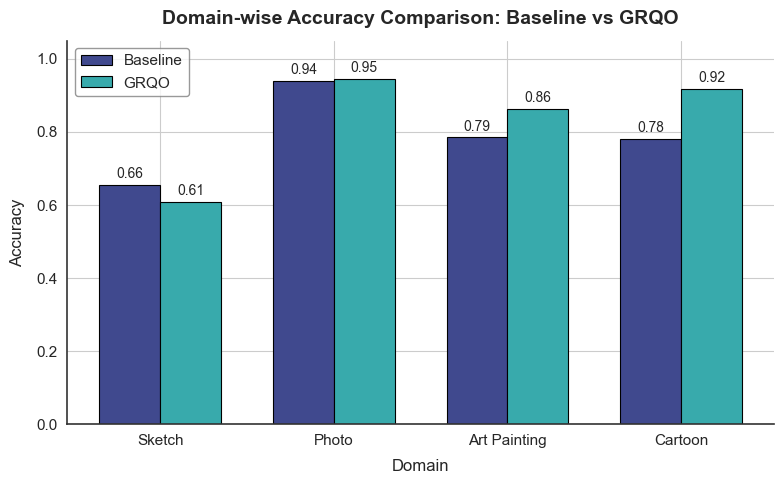

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set clean modern style
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.figsize": (8, 5),
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2
})

# New data
domains = ["Sketch", "Photo", "Art Painting", "Cartoon"]
baseline = [0.6552, 0.9401, 0.7854, 0.7804]
grqo = [0.6094, 0.9461, 0.8634, 0.9190]

x = np.arange(len(domains))
width = 0.35

# Elegant color palette (mako gives a premium feel)
colors = sns.color_palette("mako", 2)

fig, ax = plt.subplots()

# Bars
bars1 = ax.bar(x - width/2, baseline, width, label='Baseline',
               color=colors[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, grqo, width, label='GRQO',
               color=colors[1], edgecolor='black', linewidth=0.8)

# Labels & Titles
ax.set_ylabel('Accuracy', labelpad=8)
ax.set_xlabel('Domain', labelpad=8)
ax.set_title('Domain-wise Accuracy Comparison: Baseline vs GRQO', 
             pad=12, fontweight='semibold')
ax.set_xticks(x)
ax.set_xticklabels(domains)
ax.set_ylim(0, 1.05)

# Add values above bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f"{height:.2f}", ha='center', va='bottom', fontsize=10, fontweight='medium')

annotate_bars(bars1)
annotate_bars(bars2)

# Legend styling
ax.legend(frameon=True, fancybox=True, shadow=False, facecolor='white', 
          edgecolor='gray', loc='upper left')

# Clean up visual clutter
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()
